# Final ML Project
## Daniel Bernal, Raymond Vuong, Rohit Punjani, and Neal Davar 


In [126]:
# import statements

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold


In [78]:
# Constants and other global variables: 

IL_F_ITERATIONS = 50

In [114]:
# clean data by dropping cols like Id, imputing value
# depending on the feature, and dropping duplicates:
def clean_data(dataset, is_training): 
    dataset.drop('Id', axis=1, inplace=True)

    if is_training: 
        dataset = dataset.drop('SalePrice', axis=1, inplace=False)
    
    null_counts = dataset.isnull().sum()
    missing_features = null_counts[null_counts > 0]
    print(missing_features)    
    
   
    # fillna on the basis of whether MasVnrArea, LotFrontage, or any other categorical feature with na values
    dataset['MSZoning'].fillna('None', inplace=True)
    dataset['LotFrontage'].fillna(0, inplace=True)
    dataset['Alley'].fillna('None', inplace=True)
    dataset['Utilities'].fillna('None', inplace=True)
    dataset['Exterior1st'].fillna('None', inplace=True)
    dataset['Exterior2nd'].fillna('None', inplace=True)
    dataset['MasVnrType'].fillna('None', inplace=True)
    dataset['MasVnrArea'].fillna(0, inplace=True)
    dataset['BsmtQual'].fillna('None', inplace=True)
    dataset['BsmtCond'].fillna('None', inplace=True)
    dataset['BsmtExposure'].fillna('None', inplace=True)
    dataset['BsmtFinType1'].fillna('None', inplace=True)
    dataset['BsmtFinSF1'].fillna(0, inplace=True)
    dataset['BsmtFinType2'].fillna('None', inplace=True)
    dataset['BsmtFinSF2'].fillna(0, inplace=True)
    dataset['BsmtUnfSF'].fillna(0, inplace=True)
    dataset['TotalBsmtSF'].fillna(0, inplace=True)
    dataset['BsmtFullBath'].fillna(0, inplace=True)
    dataset['BsmtHalfBath'].fillna(0, inplace=True)
    dataset['KitchenQual'].fillna('None', inplace=True)
    dataset['Functional'].fillna('None', inplace=True)
    dataset['FireplaceQu'].fillna('None', inplace=True)
    dataset['GarageType'].fillna('None', inplace=True)
    dataset['GarageYrBlt'].fillna(dataset['GarageYrBlt'].mean(), inplace=True)
    dataset['GarageFinish'].fillna('None', inplace=True)
    dataset['GarageCars'].fillna(0, inplace=True)
    dataset['GarageArea'].fillna(0, inplace=True)
    dataset['GarageQual'].fillna('None', inplace=True)
    dataset['GarageCond'].fillna('None', inplace=True)
    dataset['PoolQC'].fillna('None', inplace=True)
    dataset['Fence'].fillna('None', inplace=True)
    dataset['MiscFeature'].fillna('None', inplace=True)
    dataset['SaleType'].fillna('None', inplace=True)

    # drop duplicates:
    dataset.drop_duplicates(keep=False, inplace=True)

    # Changing categorial features to be stored as string
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)

    print(((is_training and "Training: ") or (not is_training and "Testing: ")), dataset.describe)

    return dataset

In [112]:
# on hot encode the data
def one_hot_encode(dataset):
    ohe_col_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']   

    dataset_dropped = pd.get_dummies(data=dataset, columns=ohe_col_list, drop_first=True)

    return dataset_dropped

In [116]:
def explore_data(dataset):
    # grab all the numeric features and plot histograms
    numeric_feats = dataset.select_dtypes(
    include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    for i in numeric_feats.columns:
        plt.hist(numeric_feats[i])
        plt.title(i)
        plt.show()

    # plot correlation between features: 
    corr_mat = dataset.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corr_mat, square=True)

In [80]:
# TODO: ASK ANSHUL!!
def one_hot_encoder(training, testing):
   
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
    labels = training['SalePrice']
    training_features = training.drop('SalePrice', axis=1)
    ohe.fit(training_features)
    transform_training = pd.DataFrame(ohe.transform(training_features).toarray())
    print(ohe.get_feature_names_out())
    transform_testing = pd.DataFrame(ohe.transform(testing).toarray())

    pd.concat([transform_training, labels], axis=1)

    print(transform_training)
    print(transform_testing)

    return transform_training, transform_testing


In [81]:
# Uses the isolation forest technique to find outliers across 50 iterations
# and removes records that are recorded as outliers > 10% of the time
def run_isolation_forest(training):
    # use isolation forests to find potential outliers:
    freq_outlier_map = {} 
    for i in range(0, IL_F_ITERATIONS):
        anomalies = IsolationForest().fit_predict(training, 0.5)
        training['anomalies'] = anomalies
        outlier_indices = training.loc[training['anomalies'] == -1].index
        # add outlier freqs to map
        for j in range(0, len(outlier_indices)):
            count = 0
            if outlier_indices[j] in freq_outlier_map: 
                count = freq_outlier_map[outlier_indices[j]]
            freq_outlier_map[outlier_indices[j]] = count + 1
        
        inlier_indices = training.loc[training['anomalies'] == 1].index
        

        
    # drop outliers that are detected as anomalies more than 10% of the time
    final_outlier_indices = []
    print('Total # of Outliers: ')
    for outlier_index in freq_outlier_map.keys(): 
        if freq_outlier_map[outlier_index] > (0.10 * IL_F_ITERATIONS):
            final_outlier_indices.append(outlier_index)
    print(len(final_outlier_indices))
    print('Number of data points before outlier removal: ')
    print(len(training))
    training.drop(index=final_outlier_indices, inplace=True)
    print('Number of data points before after outlier removal: ')
    print(len(training))


In [82]:
# function that normalizes the training and testing data:
def normalize_data(train, test):
    # your code goes here
    train_norm = (train - train.min()) / (train.max() - train.min())
    test_norm = (test - test.min()) / (test.max() - test.min())
    return train_norm, test_norm

In [83]:
# feature engineering of consolidating bathroom
def fe_bathrooms(dataset):
    # consolidate bathroom columns into one col:
    dataset['TotalBathrooms'] = \
        dataset['FullBath'] + (0.5 * dataset['HalfBath']) + \
        dataset['BsmtFullBath'] + (0.5 * dataset['BsmtHalfBath'])
    dataset.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

In [84]:
# feature engineering of consolidating porch sq ft: 
def fe_porch(dataset):
    # consolidate porch area into one column
    dataset['TotalPorchSF'] = dataset['OpenPorchSF'] + \
        dataset['EnclosedPorch'] + \
        dataset['3SsnPorch'] + dataset['ScreenPorch']

    dataset.drop(['OpenPorchSF', 'EnclosedPorch',
                  '3SsnPorch', '3SsnPorch'], axis=1)


In [128]:
# Run Decision Tree Regression on our Data: 
def do_decision_tree_regression(training):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis=1)
  x_train, x_test, y_train, y_test = train_test_split(
      features, labels, test_size=0.20)
  dt = DecisionTreeRegressor(random_state=2)
  dt.fit(x_train, y_train)
  # Prediction = np.zeros((len(y_test), 1))
  Prediction = dt.predict(x_test)
  print("R2 Score No Crossval")
  print(metrics.r2_score(y_test, Prediction))
  print("MSE")
  print(metrics.mean_squared_error(y_test, Prediction))

  #outerloop of crossval
  cv = cross_val_score(dt, features, labels, cv=10)
  r2 = sum(cv) / cv.size
  # print(r2)
  #innerloop of crossval
  parameters = {'max_depth': [5, 10, 15, 20, 30, 40], 'min_samples_leaf': [
      5, 10, 15, 20, 30, 40], 'max_features': [5, 10, 15, 30, 40]}
  grid = GridSearchCV(DecisionTreeRegressor(),
                      param_grid=parameters, cv=10, scoring='r2')
  grid.fit(features, labels)
  print("Best parameters")
  print(grid.best_params_)
  # print(grid.best_score_)

  #combined
  cv = cross_val_score(grid, features, labels, cv=5)
  r2 = sum(cv)/cv.size
  print("R2 with cross val")
  print(r2)

In [127]:
# run adaboost regression on training data
def do_adaBoost(training):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis=1)
  x_train, x_test, y_train, y_test = train_test_split(
      features, labels, test_size=0.20)
  dt = AdaBoostRegressor(random_state=2)
  dt.fit(x_train, y_train)
  # Prediction = np.zeros((len(y_test), 1))
  Prediction = dt.predict(x_test)
  print("R2 Score No Crossval")
  print(metrics.r2_score(y_test, Prediction))
  print("MSE")
  print(metrics.mean_squared_error(y_test, Prediction))

  #outerloop of crossval
  # cv = cross_val_score(dt, features, labels, cv=10)
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
  #innerloop of crossval
  parameters = {'n_estimators': [10, 20, 30,
                                 40, 50, 60], 'random_state': [5, 10, 15]}
  grid = GridSearchCV(AdaBoostRegressor(),
                      param_grid=parameters, cv=cv_inner, scoring='r2')
  grid.fit(features, labels)
  print("Best parameters")
  print(grid.best_params_)
  # print(grid.best_score_)
  cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
  #combined
  cv = cross_val_score(grid, features, labels, cv=cv_outer)
  r2 = sum(cv)/cv.size
  print("R2 with cross val")
  print(r2)


In [86]:
# KNN Regression Model Implementation: 
#KNN regression
def do_KNN_regression(training):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis=1)
  x_train, x_test, y_train, y_test = train_test_split(
      features, labels, test_size=0.20)
  dt = KNeighborsRegressor()
  dt.fit(x_train, y_train)
  # Prediction = np.zeros((len(y_test), 1))
  Prediction = dt.predict(x_test)
  print("R2 Score No Crossval")
  print(metrics.r2_score(y_test, Prediction))
  print("MSE")
  print(metrics.mean_squared_error(y_test, Prediction))

  #outerloop of crossval
  cv = cross_val_score(dt, features, labels, cv=10)
  r2 = sum(cv) / cv.size
  # print(r2)
  #innerloop of crossval
  parameters = {'n_neighbors': [5, 10, 15, 20, 30, 40]}
  grid = GridSearchCV(KNeighborsRegressor(),
                      param_grid=parameters, cv=10, scoring='r2')
  grid.fit(features, labels)
  print("Best parameters")
  print(grid.best_params_)
  # print(grid.best_score_)

  #combined
  cv = cross_val_score(grid, features, labels, cv=5)
  r2 = sum(cv)/cv.size
  print("R2 with cross val")
  print(r2)


In [121]:
# run a linear regression model
def runLinReg(train_norm):
    labels = train_norm['SalePrice']
    labels.values.ravel()
    features = train_norm.drop('SalePrice', axis=1)
    print(features.shape)
    print(labels.shape)
    print(features.head())
    print(labels.head())


    linReg = LinearRegression()
    scores = cross_val_score(linReg, features, labels, cv=10)
    
    y_pred = cross_val_predict(linReg, features, labels, cv=10)
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    # plot cross_val_predict() results
    axs[0].scatter(labels, y_pred)
    axs[0].plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--', lw=4)
    axs[0].set_xlabel('Measured')
    axs[0].set_ylabel('Predicted')
    # plot residuals
    axs[1].scatter(y_pred, y_pred - labels)
    axs[1].hlines(y=0, xmin=labels.min(), xmax=labels.max())
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Residual')
    plt.show()
    

    print("Accuracy:", scores.mean()*100)


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Training:  <bound method NDFrame.describe of      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave  None      Reg   
1            20       RL         80.0     9600   Pave  None      Reg   
2            60       RL         68.0    11250   Pave  None      IR1   
3            70       RL         60.0     9550   Pave  None      IR1   
4            60       RL         84.0    14260   Pave  None      IR1   
5            50       RL         85.0    14115   Pave  None      IR1   
6            20       RL         75.0  

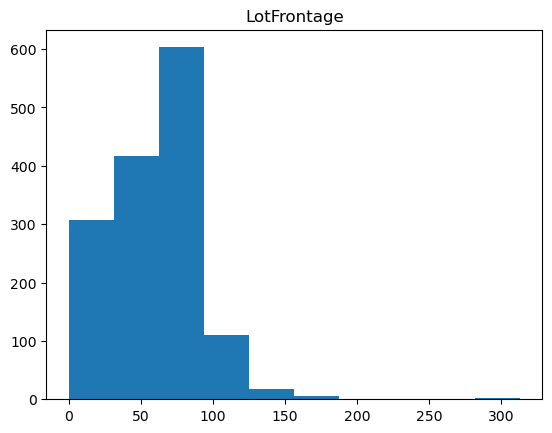

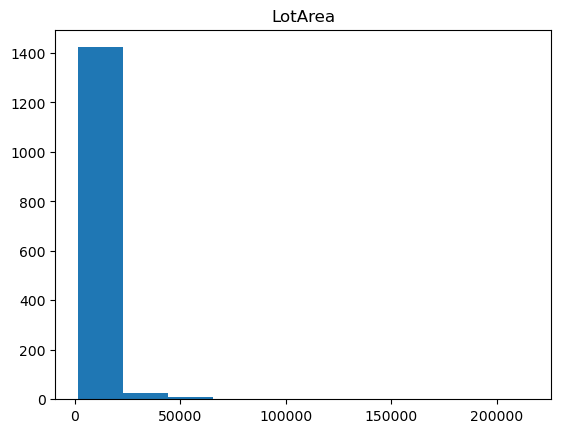

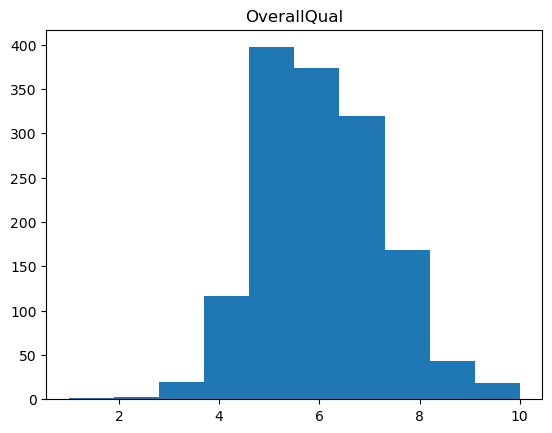

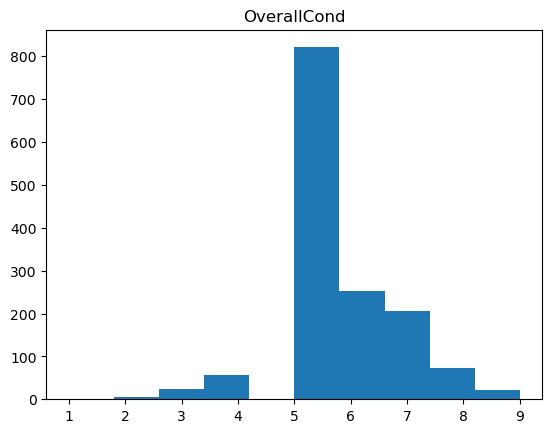

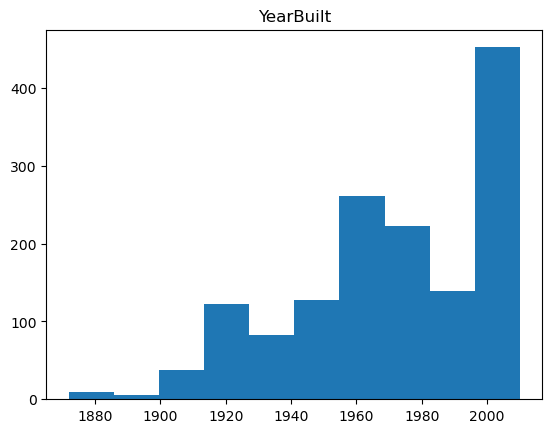

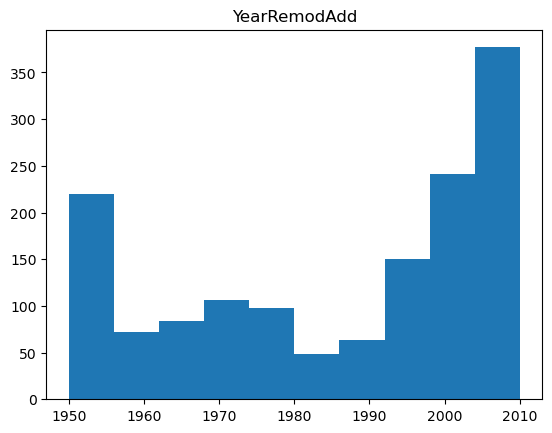

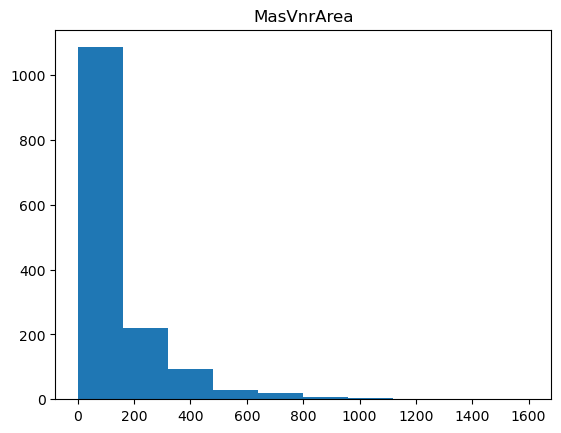

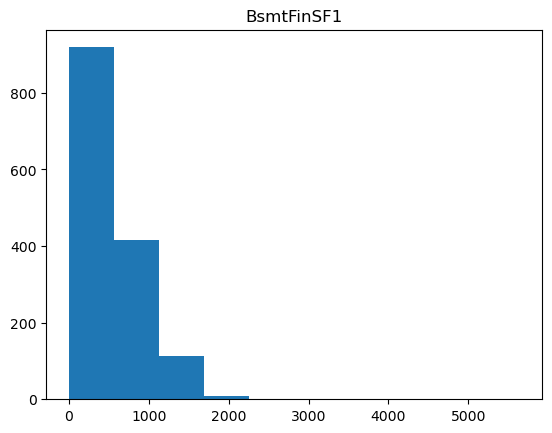

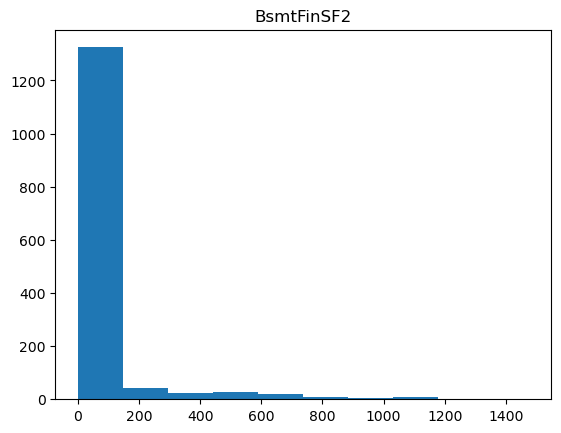

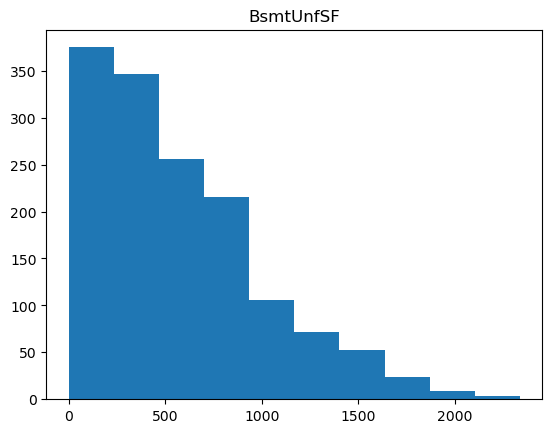

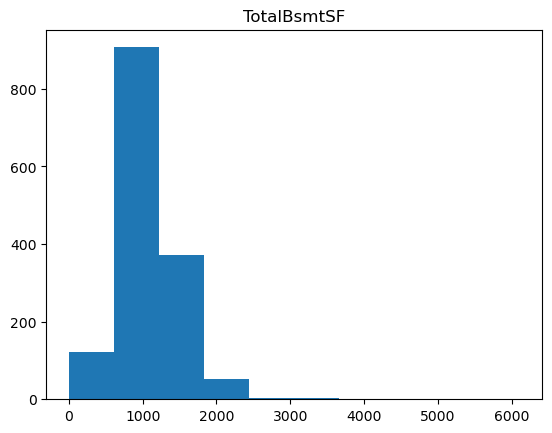

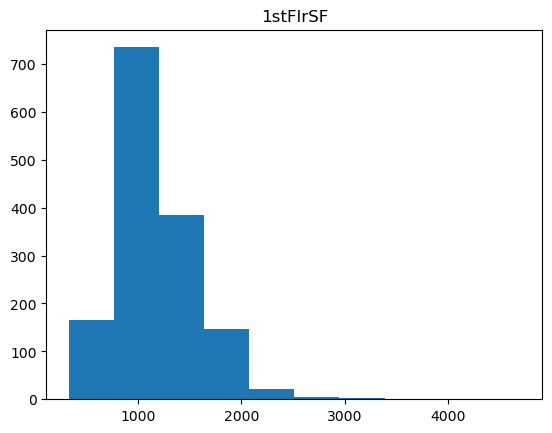

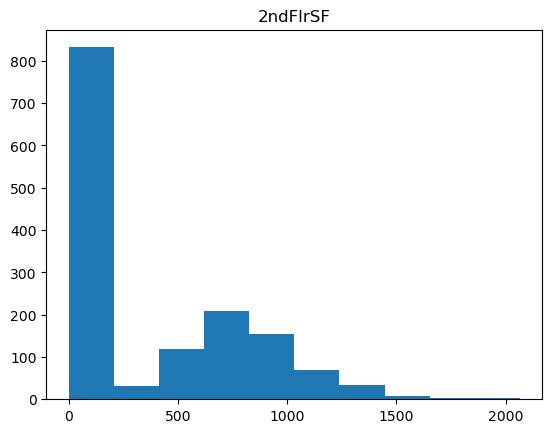

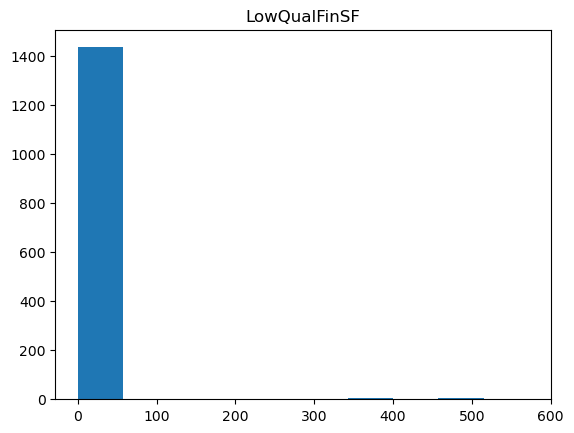

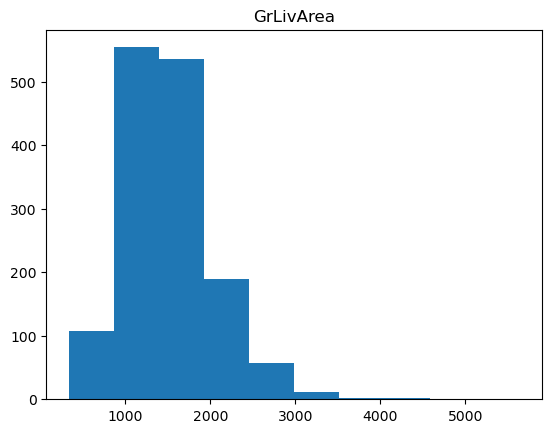

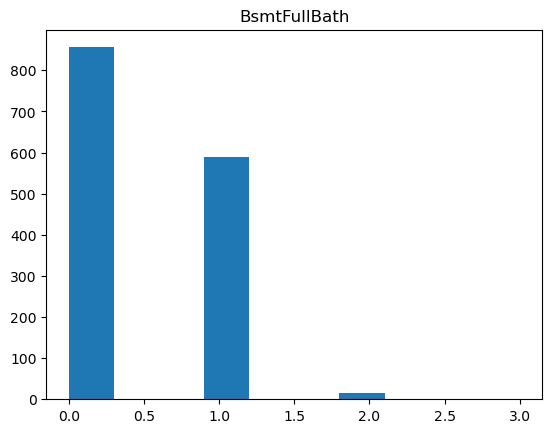

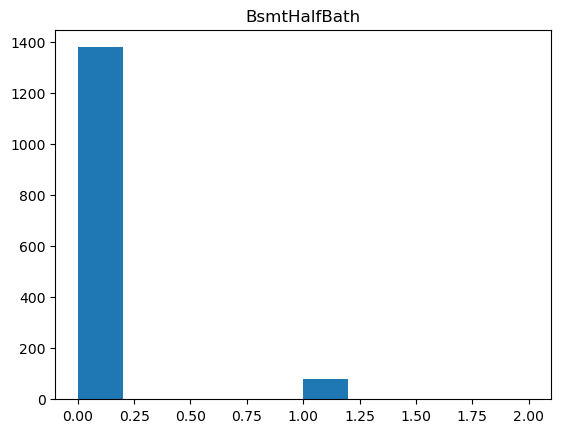

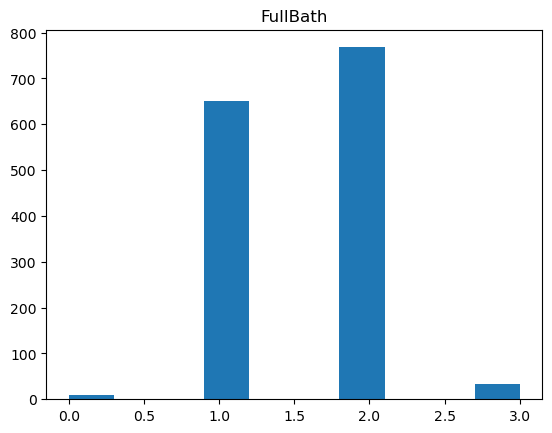

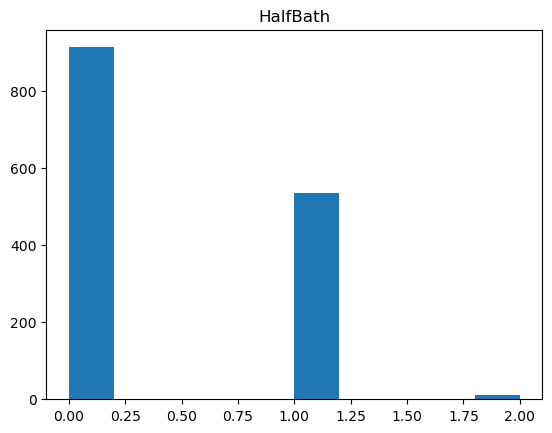

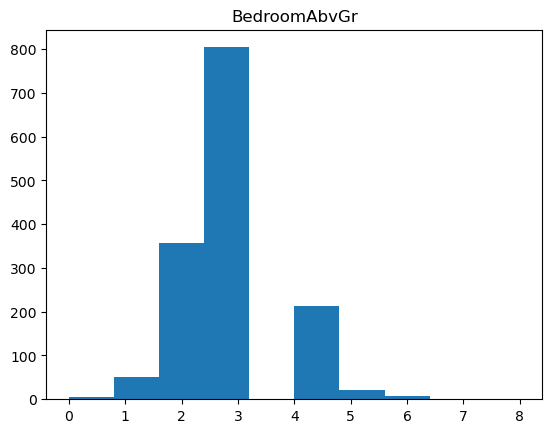

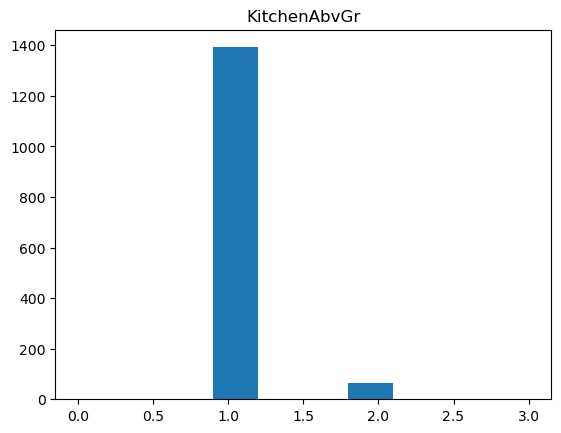

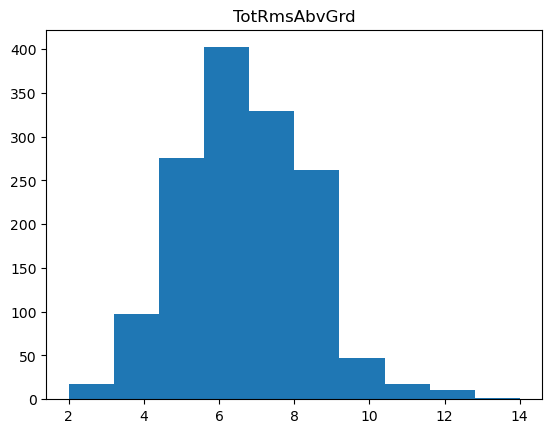

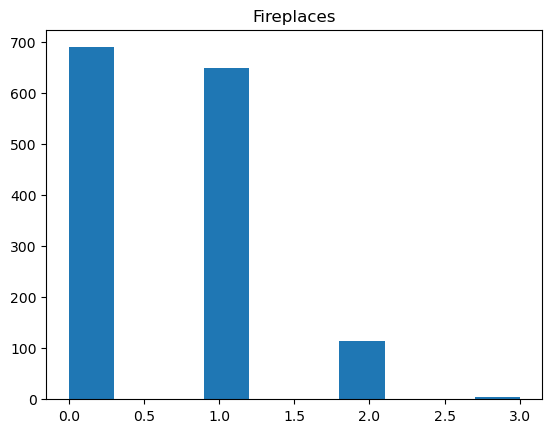

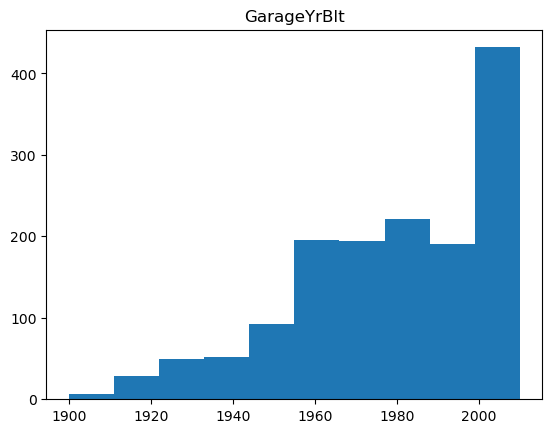

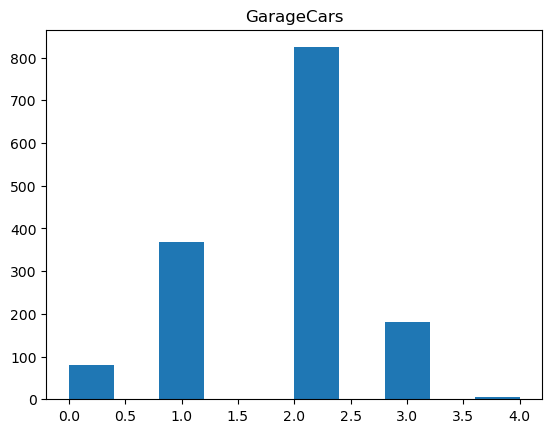

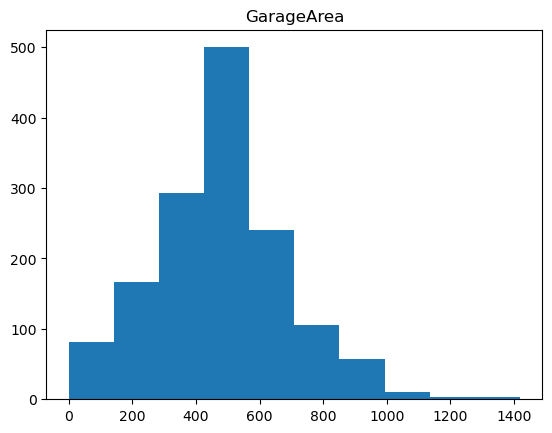

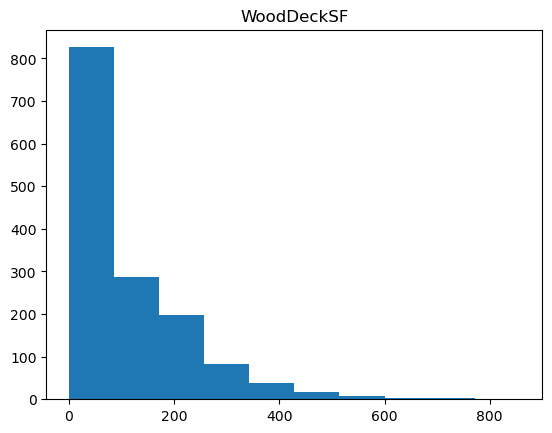

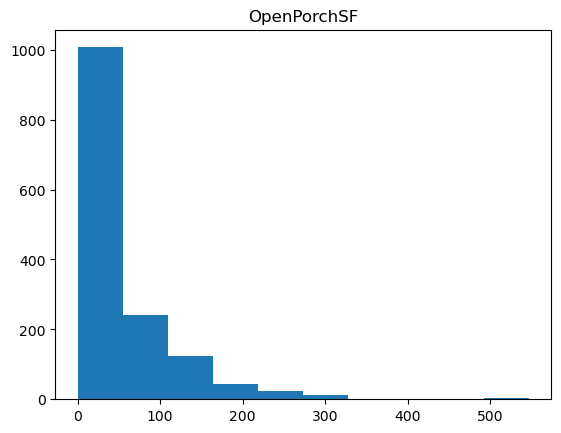

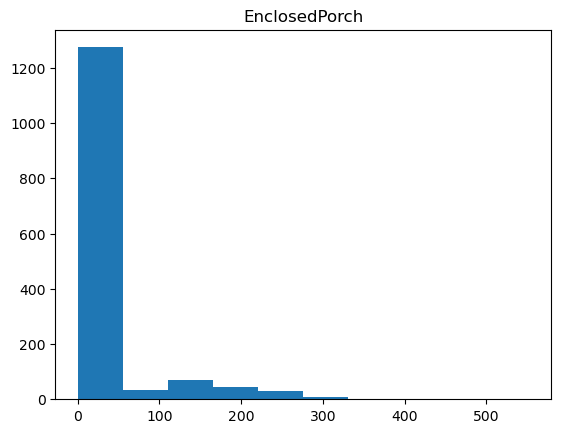

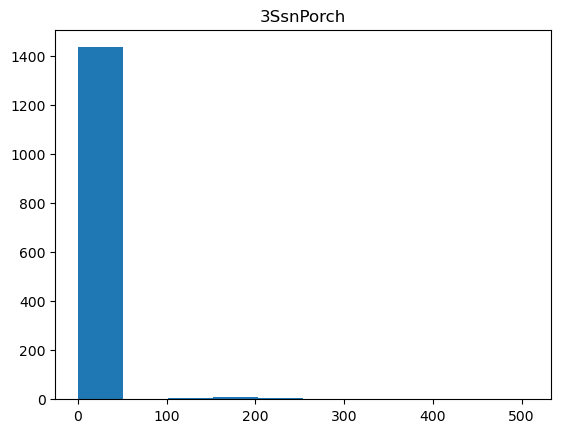

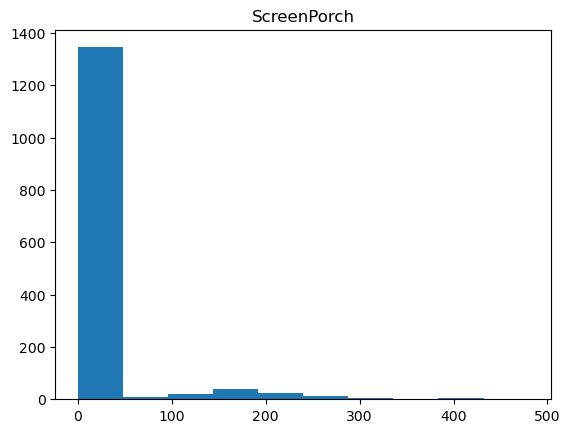

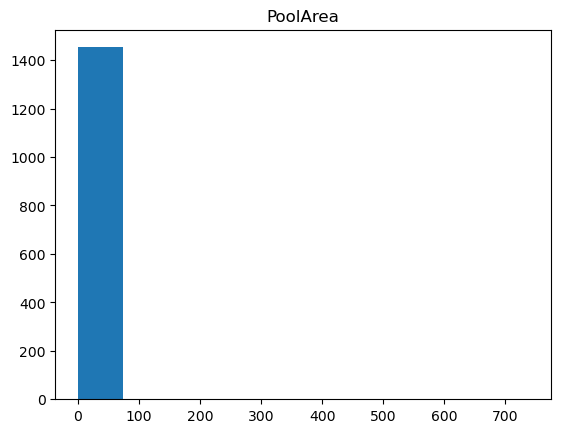

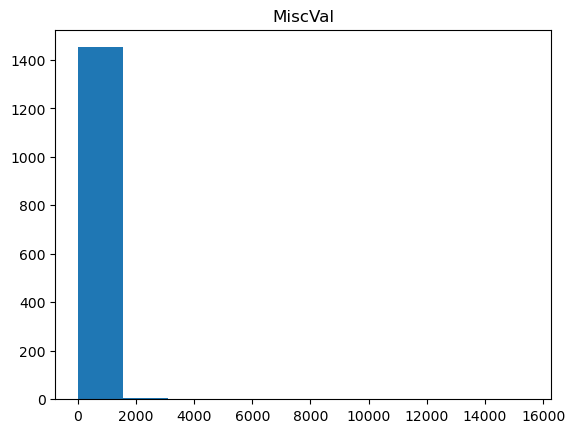

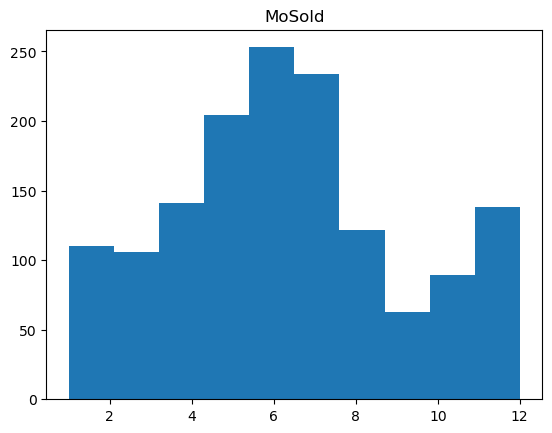

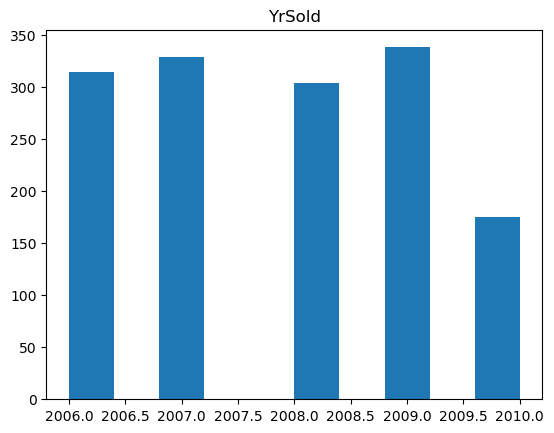

Linear Regression
(1460, 254)
(1460,)
   LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     0.207668  0.033420     0.666667        0.500   0.949275      0.883333   
1     0.255591  0.038795     0.555556        0.875   0.753623      0.433333   
2     0.217252  0.046507     0.666667        0.500   0.934783      0.866667   
3     0.191693  0.038561     0.666667        0.500   0.311594      0.333333   
4     0.268371  0.060576     0.777778        0.500   0.927536      0.833333   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLI  \
0     0.12250    0.125089         0.0   0.064212  ...             0.0   
1     0.00000    0.173281         0.0   0.121575  ...             0.0   
2     0.10125    0.086109         0.0   0.185788  ...             0.0   
3     0.00000    0.038271         0.0   0.231164  ...             0.0   
4     0.21875    0.116052         0.0   0.209760  ...             0.0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  S

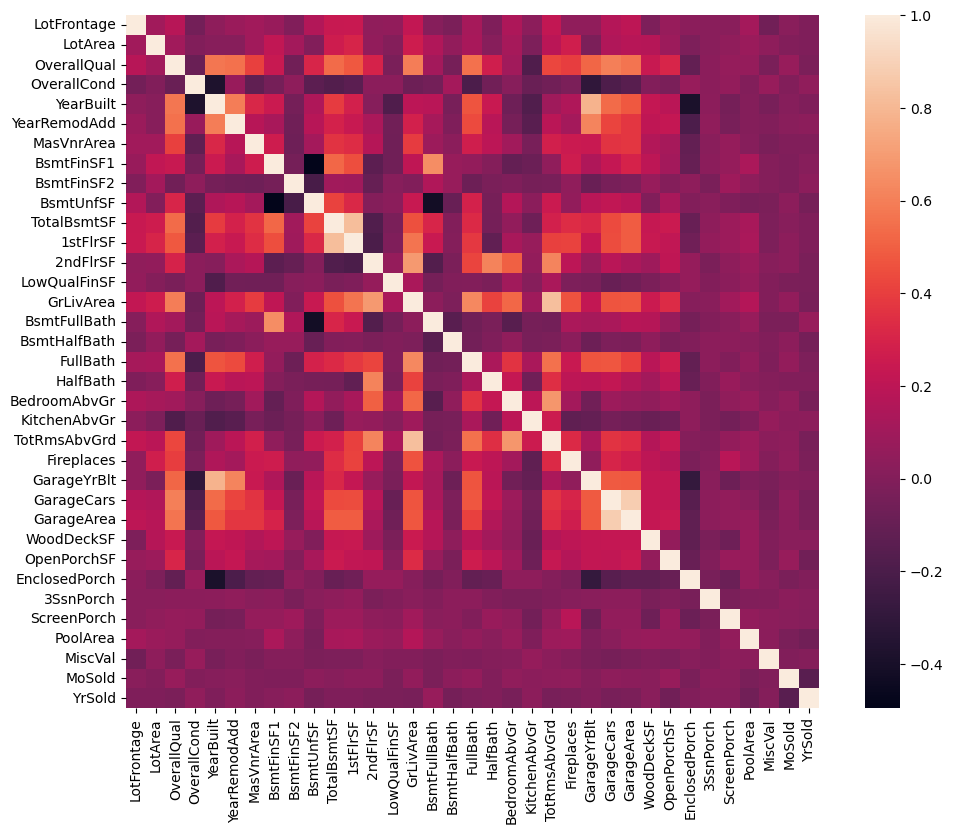

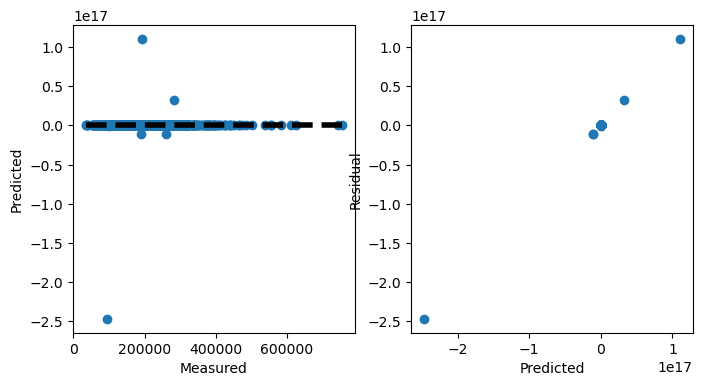

Accuracy: -8.856985832172972e+23
KNN Regression
R2 Score No Crossval
0.6890842383181004
MSE
1565281048.2769864
Best parameters
{'n_neighbors': 5}
R2 with cross val
0.717551473712174
ADABOOST REGRESSION
R2 Score No Crossval
0.7996597572099003
MSE
1073334402.113104
Best parameters
{'n_estimators': 60, 'random_state': 15}
R2 with cross val
0.7811324589787159
DECISION TREE REGRESSION
R2 Score No Crossval
0.5677780529989052
MSE
3337978964.349315
Best parameters
{'max_depth': 40, 'max_features': 40, 'min_samples_leaf': 5}
R2 with cross val
0.7051578882783741


In [129]:

training = pd.read_csv("train.csv")
testing = pd.read_csv("housing_testing.csv")
pd.options.display.max_rows = 10_000
labels = training['SalePrice']


# 1. Clean Data
training = clean_data(training, True)
testing = clean_data(testing, False)

#2. Explore Data
explore_data(training)

#  one hot encode and do an inner join to make sure we have the same shape in test and train
ohe_train = one_hot_encode(training)
ohe_test = one_hot_encode(testing)
final_train, final_test = ohe_train.align(ohe_test, join='inner', axis=1)


# 3. Normalization
train_norm, test_norm = normalize_data(final_train, final_test)

train_norm['SalePrice'] = labels

# 4. Run Models
print("Linear Regression")
runLinReg(train_norm)
print("KNN Regression")
do_KNN_regression(train_norm)
print("ADABOOST REGRESSION")
do_adaBoost(train_norm)
print("DECISION TREE REGRESSION")
do_decision_tree_regression(train_norm)
